In [ ]:
# Import necessary libraries
from google.colab import files
import pandas as pd
from google.colab import drive
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/MLAssignment/Insurance_Updated.xlsx")

# List of features to drop
features_to_drop = [
    'policy_state',
    'policy_csl',
    'insured_sex',
    'insured_education_level',
    'insured_occupation',
    'insured_hobbies',
    'insured_relationship',
    'incident_type',
    'collision_type',
    'incident_severity',
    'authorities_contacted',
    'incident_state',
    'incident_city',
    'incident_location',
    'property_damage',
    'police_report_available',
    'auto_make',
    'auto_model',
    '_c39'
]

# Drop the specified features from the dataframe
df.drop(columns=features_to_drop, inplace=True)

# Check for and remove any NaN values in the dataframe
df.dropna(inplace=True)

# Encoding fraud_reported (dependent variable column)
le = preprocessing.LabelEncoder()
df['fraud_reported'] = le.fit_transform(df['fraud_reported'])

# Separate features and target variable
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the dataset size for quicker training
X_scaled, _, y, _ = train_test_split(X_scaled, y, test_size=0.95, random_state=42)

# Generator
def build_generator(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(X_scaled.shape[1], activation='sigmoid')
    ])
    return model

# Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(64),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile the discriminator
discriminator = build_discriminator(X_scaled.shape[1])
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the generator
generator = build_generator(input_dim=100)

# Combined model
z = tf.keras.Input(shape=(100,))
synthetic_data = generator(z)
discriminator.trainable = False
validity = discriminator(synthetic_data)
combined = tf.keras.Model(z, validity)
combined.compile(optimizer='adam', loss='binary_crossentropy')

# Hyperparameters
epochs = 100  # Increased epochs
batch_size = 64  # Increased batch size
sample_interval = 10  # Print progress every 10 epochs

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Train the GAN
for epoch in range(epochs):
    np.random.shuffle(X_scaled)

    for batch_idx in range(0, len(X_scaled), batch_size):
        real_data = X_scaled[batch_idx:batch_idx + batch_size]
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a batch of synthetic fraudulent transactions
        gen_data = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, valid[:real_data.shape[0]])
        d_loss_fake = discriminator.train_on_batch(gen_data, fake[:gen_data.shape[0]])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid[:noise.shape[0]])

    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | G loss: {g_loss}]")

# Generate synthetic data
num_samples = 1000000
noise = np.random.normal(0, 1, (num_samples, 100))
synthetic_data = generator.predict(noise)

# Rescale synthetic data back to original scale (if necessary)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data_rescaled, columns=X.columns)

# Combine with original data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

# Check for and remove any NaN values in the augmented dataframe
augmented_df.dropna(inplace=True)

# Shuffle the data
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

# Save the augmented data to a new Excel file
augmented_df.to_excel("/content/drive/MyDrive/MLAssignment/Augmented_Insurance_Updated.xlsx", index=False)

# Splitting augmented data for training a deep learning model
X_augmented = augmented_df.drop(columns=['fraud_reported'])
y_augmented = augmented_df['fraud_reported']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_augmented, y_augmented)

# Standardize the features for the CNN
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Reshape the input data for CNN (add an additional dimension for channels)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Optional dropout layer for regularization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model
history = cnn_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the CNN model on the testing data
loss, accuracy = cnn_model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predictions and performance metrics
y_pred = (cnn_model.predict(X_test_reshaped) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6776715517044067 | G loss: [array(0.77301395, dtype=float32), array(0.77301395, dtype=float32), array(0.37719297, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10 [D loss: 0.7999875545501709 | G loss: [array(0.806749, dtype=float32), array(0.806749, dtype=float32), array(0.39792663, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5746 - loss: 0.6844 - val_accuracy: 0.5062 - val_loss: 0.6842
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6028 - loss: 0.6704 - val_accuracy: 0.5851 - val_loss: 0.6671
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6161 - loss: 0.6382 - val_accuracy: 0.6058 - val_loss: 0.6554
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6571 - loss: 0.6277 - val_accuracy: 0.5685 - val_loss: 0.6492
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6741 - loss: 0.6298 - val_accuracy: 0.6390 - val_loss: 0.6412
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6923 - loss: 0.6093 - val_accuracy: 0.5975 - val_loss: 0.6515
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6931 - loss: 0.5839 - val_accuracy: 0.6432 - val_loss: 0.6245
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7081 - loss: 0.5784 - val_accuracy: 0.6473 - val_loss: 0.6284
Ep

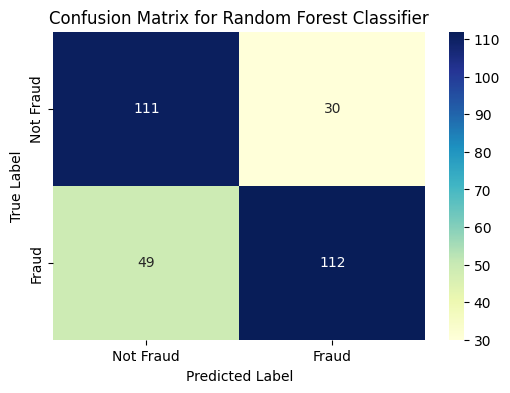

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()
